In [13]:
import pandas as pd
from geopy.distance import geodesic

### 1. Aggregate ridership by different granuality of time

In [6]:
df_MTA = pd.read_csv('MTA_Subway_Hourly_Ridership__2020-2024_20250429.csv')
df_MTA.head()

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference
0,01/01/2023 12:00:00 AM,subway,240,"7 Av (F,G)",Brooklyn,metrocard,Metrocard - Full Fare,46,1,40.666270,-73.98031,POINT (-73.98031 40.66627)
1,01/01/2023 12:00:00 AM,subway,164,"34 St-Penn Station (A,C,E)",Manhattan,metrocard,Metrocard - Other,33,0,40.752290,-73.99339,POINT (-73.99339 40.75229)
2,01/01/2023 12:00:00 AM,subway,453,82 St-Jackson Hts (7),Queens,omny,OMNY - Full Fare,22,0,40.747658,-73.88370,POINT (-73.8837 40.747658)
3,01/01/2023 12:00:00 AM,subway,9,"57 St-7 Av (N,Q,R,W)",Manhattan,metrocard,Metrocard - Seniors & Disability,13,0,40.764664,-73.98066,POINT (-73.98066 40.764664)
4,01/01/2023 12:00:00 AM,subway,357,"Beverly Rd (2,5)",Brooklyn,metrocard,Metrocard - Full Fare,1,0,40.645100,-73.94896,POINT (-73.94896 40.6451)


In [50]:
# check dtype
df_MTA['transit_timestamp'] = pd.to_datetime(df_MTA['transit_timestamp'], format='%m/%d/%Y %I:%M:%S %p')
df_MTA['date'] = df_MTA['transit_timestamp'].dt.date
df_MTA['month'] = df_MTA['transit_timestamp'].dt.to_period('M')

# aggregate by day
df_MTA_daily = (
    df_MTA
    .groupby(['date', 'station_complex_id', 'fare_class_category'])['ridership']
    .sum()
    .reset_index()
)

# aggregate by month
df_MTA_monthly = (
    df_MTA
    .groupby(['month', 'station_complex_id', 'fare_class_category'])['ridership']
    .sum()
    .reset_index()
)

print(df_MTA_daily.shape)
print(df_MTA_monthly.shape)

(1385938, 4)
(50989, 4)


In [10]:
df_demo = pd.read_csv('StationComplex_Demographics.csv')
df_demo.head()

,Complex_ID,Latitude,Longitude,MEAN_Median_Inc,SUM_Total_Popu,SUM_Male_Total,SUM_Female_Tot,SUM_White_Alon,SUM_Black_Alon,SUM_Hispanic_L,SUM_Non_Hispan
0,398,40.773620,-73.959874,134178.7500,47275,20936,26339,40094,372,44312,2963
1,399,40.768141,-73.963870,177047.8889,44931,19397,25534,36445,576,41252,3679
2,403,40.746081,-73.982076,155538.0000,48537,23030,25507,29953,2794,43228,5309
3,404,40.743070,-73.984264,183811.0000,53878,26223,27655,34329,3474,48862,5016
4,405,40.739864,-73.986599,176921.1000,60407,28990,31417,39826,4033,55036,5371


In [53]:
print(df_demo.shape)

(445, 11)


### 2. Merge df_demo & df_MTA_monthly with 'complex_station_id'

In [58]:
# check info of 'station_complex_id' from df_MTA_monthly
num_station_mta = df_MTA['station_complex_id'].nunique()
print(f"the # of unique values of 'station_complex_id' is: {num_station_mta}")
print("the dtype of 'station_complex_id' is:", df_MTA_monthly['station_complex_id'].dtype)

# # check info of 'Complex_ID' from df_demo
num_station_demo = df_demo['Complex_ID'].nunique()
print(f"the # of unique values of 'Complex_ID' is: {num_station_demo}")
print("the dtype of 'Complex_ID' is:", df_demo['Complex_ID'].dtype)

the # of unique values of 'station_complex_id' is: 428
the dtype of 'station_complex_id' is: object
the # of unique values of 'Complex_ID' is: 445
the dtype of 'Complex_ID' is: int32


In [60]:
# check the difference
df_MTA_monthly['station_complex_id'] = pd.to_numeric(df_MTA_monthly['station_complex_id'], errors='coerce')
df_demo['Complex_ID'] = pd.to_numeric(df_demo['Complex_ID'], errors='coerce')

# get set
mta_ids = set(df_MTA_monthly['station_complex_id'].unique())
demo_ids = set(df_demo['Complex_ID'].unique())
unmatched_ids = demo_ids - mta_ids
unmatched_df = df_demo[df_demo['Complex_ID'].isin(unmatched_ids)]

print(f"🚨there are {len(unmatched_ids)} values from df_demo cannot be matched with Complex_ID from df_MTA_monthly.")
unmatched_df.head()

🚨there are 19 values from df_demo cannot be matched with Complex_ID from df_MTA_monthly.


,Complex_ID,Latitude,Longitude,MEAN_Median_Inc,SUM_Total_Popu,SUM_Male_Total,SUM_Female_Tot,SUM_White_Alon,SUM_Black_Alon,SUM_Hispanic_L,SUM_Non_Hispan
61,503,40.627915,-74.075162,54029.25,14372,6784,7588,5943,3755,9410,4962
62,504,40.621319,-74.071402,58752.25,12865,6196,6669,6107,1836,9767,3098
63,505,40.603117,-74.084087,80962.00,12682,6455,6227,8406,471,11007,1675
64,506,40.596612,-74.087368,88755.00,13217,6660,6557,9796,231,12193,1024
65,507,40.588849,-74.096090,92760.00,27701,13800,13901,19188,948,24069,3632


In [62]:
# unify joined columns
# drop None values
df_MTA_monthly = df_MTA_monthly[df_MTA_monthly['station_complex_id'].notna()]
df_demo = df_demo[df_demo['Complex_ID'].notna()]

# transfer into int
df_MTA_monthly['station_complex_id'] = df_MTA_monthly['station_complex_id'].astype(int)
df_demo['Complex_ID'] = df_demo['Complex_ID'].astype(int)

# merge
merged_df_monthly = df_MTA_monthly.merge(
    df_demo,
    left_on='station_complex_id',
    right_on='Complex_ID',
    how='inner'
)

# save to .csv
merged_df_monthly.to_csv('merged_df_monthly.csv', index=False, encoding='utf-8')
print(f"Done! we got {len(merged_df_monthly)} rows")

Done! we got 50793 rows


### 3. add df_arrest with 'complex_station_id'

In [7]:
df_arrest = pd.read_csv('NYPD_Arrests_Fare_Evasion.csv')
df_ridership = pd.read_csv('demo_ridership_monthly.csv')
print(df_arrest.head())
print(df_arrest.shape)
print(df_ridership.head())
print(df_ridership.shape)

   ARREST_KEY ARREST_DATE  PD_CD                         PD_DESC  KY_CD  \
0   279748167  12/31/2023  478.0  THEFT OF SERVICES, UNCLASSIFIE  343.0   
1   279724831  12/30/2023  478.0  THEFT OF SERVICES, UNCLASSIFIE  343.0   
2   279697901  12/30/2023  478.0  THEFT OF SERVICES, UNCLASSIFIE  343.0   
3   279733241  12/30/2023  478.0  THEFT OF SERVICES, UNCLASSIFIE  343.0   
4   279733238  12/30/2023  478.0  THEFT OF SERVICES, UNCLASSIFIE  343.0   

                        OFNS_DESC    LAW_CODE LAW_CAT_CD ARREST_BORO  \
0  OTHER OFFENSES RELATED TO THEF  PL 1651503          M           Q   
1  OTHER OFFENSES RELATED TO THEF  PL 1651503          M           B   
2  OTHER OFFENSES RELATED TO THEF  PL 1651503          M           K   
3  OTHER OFFENSES RELATED TO THEF  PL 1651503          M           K   
4  OTHER OFFENSES RELATED TO THEF  PL 1651503          M           K   

   ARREST_PRECINCT  JURISDICTION_CODE AGE_GROUP PERP_SEX PERP_RACE  \
0              113                  0     25-4

In [23]:
# 获取唯一的 station_complex_id
unique_station_ids = df_ridership['station_complex_id'].unique()

# 从 df_ridership 中筛选出包含这些唯一 id 的数据
df_station = df_ridership[df_ridership['station_complex_id'].isin(unique_station_ids)]

# 只保留需要的列
df_station = df_station[['station_complex_id', 'Latitude', 'Longitude']]

# 假设 df_station 已经加载

# 删除重复行
df_station_unique = df_station.drop_duplicates()

# 查看结果
print(df_station_unique)

      station_complex_id   Latitude  Longitude
0                      1  40.775036 -73.912034
10                    10  40.759901 -73.984139
20                   100  40.706870 -73.953431
30                   101  40.708359 -73.957757
40                   103  40.720280 -73.993915
...                  ...        ...        ...
4172                  95  40.689630 -73.922270
4182                  96  40.693342 -73.928814
4192                  97  40.697207 -73.935657
4202                  98  40.700260 -73.941126
4212                  99  40.703869 -73.947408

[426 rows x 3 columns]
    station_complex_id   Latitude  Longitude
0                    1  40.775036 -73.912034
10                  10  40.759901 -73.984139
20                 100  40.706870 -73.953431
30                 101  40.708359 -73.957757
40                 103  40.720280 -73.993915


In [25]:
# 创建一个空列表，用来存储每个 df_arrest 中的 station_complex_id
station_complex_ids = []

# 遍历 df_arrest 的每一行
for arrest_idx, arrest_row in df_arrest.iterrows():
    arrest_lat = arrest_row['Latitude']
    arrest_lon = arrest_row['Longitude']
    
    # 初始化一个标志，表示是否找到了匹配的 station_complex_id
    found_station_id = None
    
    # 遍历 df_station_unique 的每一行
    for station_idx, station_row in df_station_unique.iterrows():
        station_lat = station_row['Latitude']
        station_lon = station_row['Longitude']
        
        # 计算距离
        distance = geodesic((arrest_lat, arrest_lon), (station_lat, station_lon)).meters
        
        # 如果距离小于等于50米
        if distance <= 50:
            found_station_id = station_row['station_complex_id']
            break  # 找到一个匹配的站点就可以跳出循环
    
    # 将找到的 station_complex_id 添加到 arrest 数据中
    station_complex_ids.append(found_station_id)

# 将计算得到的 station_complex_id 列添加到 df_arrest
df_arrest['station_complex_id'] = station_complex_ids

df_arrest.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat,station_complex_id
0,279748167,12/31/2023,478.0,"THEFT OF SERVICES, UNCLASSIFIE",343.0,OTHER OFFENSES RELATED TO THEF,PL 1651503,M,Q,113,0,25-44,M,BLACK,1047082,186998,40.679720,-73.773468,POINT (-73.77346806420894 40.679720040948744),NaN
1,279724831,12/30/2023,478.0,"THEFT OF SERVICES, UNCLASSIFIE",343.0,OTHER OFFENSES RELATED TO THEF,PL 1651503,M,B,46,1,25-44,M,BLACK,1010256,248770,40.849453,-73.906000,POINT (-73.90599986315169 40.84945286686186),NaN
2,279697901,12/30/2023,478.0,"THEFT OF SERVICES, UNCLASSIFIE",343.0,OTHER OFFENSES RELATED TO THEF,PL 1651503,M,K,83,1,25-44,F,BLACK,1002212,193214,40.696986,-73.935224,POINT (-73.93522383122014 40.69698630037214),97.0
3,279733241,12/30/2023,478.0,"THEFT OF SERVICES, UNCLASSIFIE",343.0,OTHER OFFENSES RELATED TO THEF,PL 1651503,M,K,79,0,25-44,F,BLACK,996546,187436,40.681137,-73.955668,POINT (-73.9556676077586 40.6811367070632),NaN
4,279733238,12/30/2023,478.0,"THEFT OF SERVICES, UNCLASSIFIE",343.0,OTHER OFFENSES RELATED TO THEF,PL 1651503,M,K,83,1,45-64,M,BLACK,1002212,193214,40.696986,-73.935224,POINT (-73.93522383122014 40.69698630037214),97.0


In [35]:
# 筛选出 'station_complex_id' 不为空的行
df_arrest_non_null = df_arrest[df_arrest['station_complex_id'].notnull()]

# 保存到 CSV 文件
df_arrest_non_null.to_csv('df_arrest_non_null.csv', index=False)

# 输出保存成功的提示
print("The DataFrame with non-null 'station_complex_id' has been saved to 'df_arrest_non_null.csv'")

The DataFrame with non-null 'station_complex_id' has been saved to 'df_arrest_non_null.csv'


In [29]:
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# 假设 df_arrest 和 df_station_unique 已经加载

# 创建一个空列表，用来存储每个 df_arrest 中的距离
distances = []

# 遍历 df_arrest 的每一行
for arrest_idx, arrest_row in df_arrest.iterrows():
    arrest_lat = arrest_row['Latitude']
    arrest_lon = arrest_row['Longitude']
    
    # 初始化一个标志，表示是否找到了匹配的站点，并记录最小距离
    min_distance = float('inf')  # 初始化为无穷大
    
    # 遍历 df_station_unique 的每一行
    for station_idx, station_row in df_station_unique.iterrows():
        station_lat = station_row['Latitude']
        station_lon = station_row['Longitude']
        
        # 计算距离
        distance = geodesic((arrest_lat, arrest_lon), (station_lat, station_lon)).meters
        
        # 更新最小距离
        if distance < min_distance:
            min_distance = distance
    
    # 将最小距离添加到 distances 列表
    distances.append(min_distance)

# 将距离数据添加到 df_arrest
df_arrest['distance_to_station'] = distances

# 查看前几行结果
print(df_arrest[['station_complex_id', 'distance_to_station']].head())


   station_complex_id  distance_to_station
0                 NaN          3414.851990
1                 NaN           124.680043
2                97.0            44.057070
3                 NaN            58.990825
4                97.0            44.057070


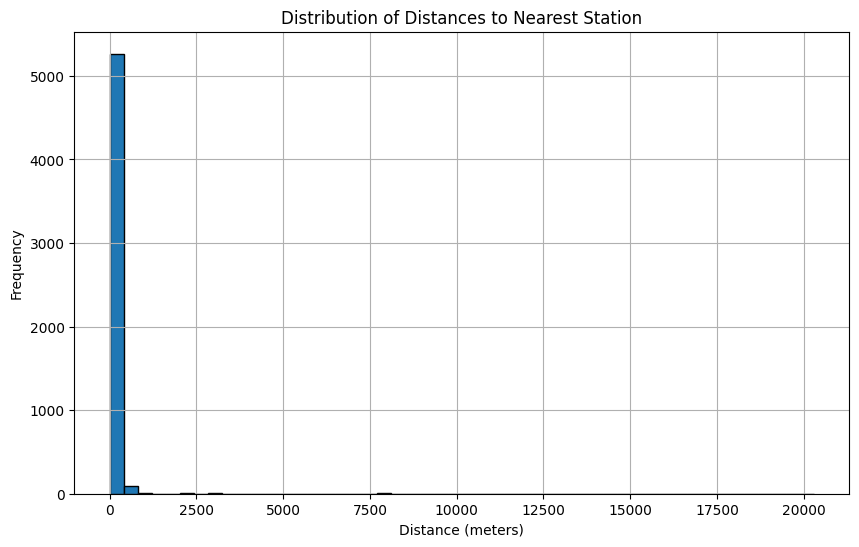

In [31]:
# 绘制距离的直方图
plt.figure(figsize=(10, 6))
plt.hist(df_arrest['distance_to_station'], bins=50, edgecolor='black')
plt.title('Distribution of Distances to Nearest Station')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [51]:
# 只保留需要的列
df_arrest_cleaned = df_arrest[['ARREST_DATE', 'ARREST_BORO', 'ARREST_PRECINCT', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'Latitude', 'Longitude', 'station_complex_id']]

# 查看清理后的结果
print(df_arrest_cleaned.head())

# 保存到 CSV 文件
df_arrest_non_null.to_csv('df_arrest_cleaned.csv', index=False)

  ARREST_DATE ARREST_BORO  ARREST_PRECINCT AGE_GROUP PERP_SEX       PERP_RACE  \
0  12/30/2023           K               83     25-44        F           BLACK   
1  12/30/2023           K               83     45-64        M           BLACK   
2  12/30/2023           K               83     45-64        M           BLACK   
3  12/30/2023           Q              110     25-44        M  WHITE HISPANIC   
4  12/30/2023           B               44     25-44        M           BLACK   

    Latitude  Longitude station_complex_id  
0  40.696986 -73.935224               97.0  
1  40.696986 -73.935224               97.0  
2  40.696986 -73.935224               97.0  
3  40.746812 -73.891752              616.0  
4  40.827812 -73.925929              604.0  


### 4. merge df_arrest with df_demo_daily

In [60]:
df_arrest = pd.read_csv('df_arrest_cleaned.csv')
df_demo = pd.read_csv('StationComplex_Demographics.csv')
print(df_arrest.head())
print(df_arrest.shape)
print(df_demo.head())
print(df_demo.shape)

  ARREST_DATE ARREST_BORO  ARREST_PRECINCT AGE_GROUP PERP_SEX       PERP_RACE  \
0  12/30/2023           K               83     25-44        F           BLACK   
1  12/30/2023           K               83     45-64        M           BLACK   
2  12/30/2023           K               83     45-64        M           BLACK   
3  12/30/2023           Q              110     25-44        M  WHITE HISPANIC   
4  12/30/2023           B               44     25-44        M           BLACK   

    Latitude  Longitude  station_complex_id  
0  40.696986 -73.935224                97.0  
1  40.696986 -73.935224                97.0  
2  40.696986 -73.935224                97.0  
3  40.746812 -73.891752               616.0  
4  40.827812 -73.925929               604.0  
(2176, 9)
   Complex_ID   Latitude  Longitude  MEAN_Median_Inc  SUM_Total_Popu  \
0         398  40.773620 -73.959874      134178.7500           47275   
1         399  40.768141 -73.963870      177047.8889           44931   
2         4

In [58]:
# 只保留需要的列
df_arrest_cleaned = df_arrest[['ARREST_DATE', 'ARREST_BORO', 'ARREST_PRECINCT', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'Latitude', 'Longitude', 'station_complex_id']]

# 查看清理后的结果
print(df_arrest_cleaned.head())

# 保存到 CSV 文件
df_arrest_cleaned.to_csv('df_arrest_cleaned.csv', index=False)

  ARREST_DATE ARREST_BORO  ARREST_PRECINCT AGE_GROUP PERP_SEX       PERP_RACE  \
0  12/30/2023           K               83     25-44        F           BLACK   
1  12/30/2023           K               83     45-64        M           BLACK   
2  12/30/2023           K               83     45-64        M           BLACK   
3  12/30/2023           Q              110     25-44        M  WHITE HISPANIC   
4  12/30/2023           B               44     25-44        M           BLACK   

    Latitude  Longitude  station_complex_id  
0  40.696986 -73.935224                97.0  
1  40.696986 -73.935224                97.0  
2  40.696986 -73.935224                97.0  
3  40.746812 -73.891752               616.0  
4  40.827812 -73.925929               604.0  


In [63]:
print(df_arrest.columns)
print(df_ridership.columns)

Index(['ARREST_DATE', 'ARREST_BORO', 'ARREST_PRECINCT', 'AGE_GROUP',
       'PERP_SEX', 'PERP_RACE', 'Latitude', 'Longitude', 'station_complex_id'],
      dtype='object')
Index(['month', 'station_complex_id', 'fare_class_category', 'ridership',
       'Complex_ID', 'Latitude', 'Longitude', 'MEAN_Median_Inc',
       'SUM_Total_Popu', 'SUM_Male_Total', 'SUM_Female_Tot', 'SUM_White_Alon',
       'SUM_Black_Alon', 'SUM_Hispanic_L', 'SUM_Non_Hispan'],
      dtype='object')


In [65]:
print("Data types of df_arrest:")
print(df_arrest.head())

print("\nData types of df_demo:")
print(df_demo.head())

Data types of df_arrest:
  ARREST_DATE ARREST_BORO  ARREST_PRECINCT AGE_GROUP PERP_SEX       PERP_RACE  \
0  12/30/2023           K               83     25-44        F           BLACK   
1  12/30/2023           K               83     45-64        M           BLACK   
2  12/30/2023           K               83     45-64        M           BLACK   
3  12/30/2023           Q              110     25-44        M  WHITE HISPANIC   
4  12/30/2023           B               44     25-44        M           BLACK   

    Latitude  Longitude  station_complex_id  
0  40.696986 -73.935224                97.0  
1  40.696986 -73.935224                97.0  
2  40.696986 -73.935224                97.0  
3  40.746812 -73.891752               616.0  
4  40.827812 -73.925929               604.0  

Data types of df_demo:
   Complex_ID   Latitude  Longitude  MEAN_Median_Inc  SUM_Total_Popu  \
0         398  40.773620 -73.959874      134178.7500           47275   
1         399  40.768141 -73.963870      177

In [67]:
# 重命名 df_demo 中的 Complex_ID 列为 station_complex_id，以便合并
df_demo.rename(columns={'Complex_ID': 'station_complex_id'}, inplace=True)

# 合并 df_arrest 和 df_demo，使用 station_complex_id 作为连接键
df_merged = pd.merge(df_arrest, df_demo, on='station_complex_id', how='left')

# 查看合并后的结果
print(df_merged.head())

  ARREST_DATE ARREST_BORO  ARREST_PRECINCT AGE_GROUP PERP_SEX       PERP_RACE  \
0  12/30/2023           K               83     25-44        F           BLACK   
1  12/30/2023           K               83     45-64        M           BLACK   
2  12/30/2023           K               83     45-64        M           BLACK   
3  12/30/2023           Q              110     25-44        M  WHITE HISPANIC   
4  12/30/2023           B               44     25-44        M           BLACK   

   Latitude_x  Longitude_x  station_complex_id  Latitude_y  Longitude_y  \
0   40.696986   -73.935224                97.0   40.697207   -73.935657   
1   40.696986   -73.935224                97.0   40.697207   -73.935657   
2   40.696986   -73.935224                97.0   40.697207   -73.935657   
3   40.746812   -73.891752               616.0   40.746746   -73.891366   
4   40.827812   -73.925929               604.0   40.827950   -73.925741   

   MEAN_Median_Inc  SUM_Total_Popu  SUM_Male_Total  SUM_Female

In [69]:
print(df_merged.shape)

(2176, 19)


In [71]:
print(df_merged.columns)

Index(['ARREST_DATE', 'ARREST_BORO', 'ARREST_PRECINCT', 'AGE_GROUP',
       'PERP_SEX', 'PERP_RACE', 'Latitude_x', 'Longitude_x',
       'station_complex_id', 'Latitude_y', 'Longitude_y', 'MEAN_Median_Inc',
       'SUM_Total_Popu', 'SUM_Male_Total', 'SUM_Female_Tot', 'SUM_White_Alon',
       'SUM_Black_Alon', 'SUM_Hispanic_L', 'SUM_Non_Hispan'],
      dtype='object')


In [87]:
df_merged.to_csv('df_arrest_demo.csv', index=False)

In [73]:
import folium

# 创建一个纽约市的地图，默认中心点为纽约市的经纬度
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# 遍历 df_merged 中的所有逃票记录，添加标记
for idx, row in df_merged.iterrows():
    lat = row['Latitude_x']
    lon = row['Longitude_x']
    
    # 添加标记到地图
    folium.Marker(
        location=[lat, lon],
        popup=f"Arrest Date: {row['ARREST_DATE']}, Borough: {row['ARREST_BORO']}",
        icon=folium.Icon(color='red')
    ).add_to(nyc_map)

# 保存地图为 HTML 文件
nyc_map.save('nyc_arrests_map.html')

# 输出提示
print("Map has been saved as 'nyc_arrests_map.html'.")


Map has been saved as 'nyc_arrests_map.html'.


### 5. Group fairness over fare evasion

#### 5.1 plot

In [89]:
df_arrest_demo = pd.read_csv('df_arrest_demo.csv')
df_arrest_demo

,ARREST_DATE,ARREST_BORO,ARREST_PRECINCT,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude_x,Longitude_x,station_complex_id,Latitude_y,Longitude_y,MEAN_Median_Inc,SUM_Total_Popu,SUM_Male_Total,SUM_Female_Tot,SUM_White_Alon,SUM_Black_Alon,SUM_Hispanic_L,SUM_Non_Hispan
0,12/30/2023,K,83,25-44,F,BLACK,40.696986,-73.935224,97.0,40.697207,-73.935657,74112.10000,35389,16856,18533,9007,11449,21077,14312
1,12/30/2023,K,83,45-64,M,BLACK,40.696986,-73.935224,97.0,40.697207,-73.935657,74112.10000,35389,16856,18533,9007,11449,21077,14312
2,12/30/2023,K,83,45-64,M,BLACK,40.696986,-73.935224,97.0,40.697207,-73.935657,74112.10000,35389,16856,18533,9007,11449,21077,14312
3,12/30/2023,Q,110,25-44,M,WHITE HISPANIC,40.746812,-73.891752,616.0,40.746746,-73.891366,75433.00000,61482,30841,30641,16282,1388,38934,22548
4,12/30/2023,B,44,25-44,M,BLACK,40.827812,-73.925929,604.0,40.827950,-73.925741,48184.75000,36512,17698,18814,5317,16733,18786,17726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2171,01/02/2023,K,75,25-44,M,BLACK,40.659113,-73.899218,136.0,40.658733,-73.899232,56750.50000,26510,11339,15171,1341,19246,20713,5797
2172,01/02/2023,K,75,45-64,M,BLACK,40.675403,-73.871914,188.0,40.675377,-73.872106,63321.22222,36142,17464,18678,2519,15696,25910,10232
2173,01/02/2023,K,90,18-24,M,WHITE HISPANIC,40.700444,-73.950757,287.0,40.700377,-73.950234,52372.60000,71226,34829,36397,44967,8550,54629,16597
2174,01/01/2023,B,42,45-64,M,WHITE HISPANIC,40.837371,-73.887767,428.0,40.837288,-73.887734,31894.00000,27089,13241,13848,2335,11071,10224,16865


In [97]:
# 假设 df_arrest_demo 是你的数据框
unique_race_values_arrest = df_arrest_demo['PERP_RACE'].unique()

# 输出唯一值
print(unique_race_values)

['BLACK' 'WHITE HISPANIC' 'BLACK HISPANIC' 'WHITE'
 'ASIAN / PACIFIC ISLANDER' 'UNKNOWN' 'AMERICAN INDIAN/ALASKAN NATIVE']


In [103]:
# 创建一个映射字典
race_mapping = {
    'WHITE': 'White',
    'WHITE HISPANIC': 'Hispanic',
    'BLACK': 'Black',
    'BLACK HISPANIC': 'Hispanic',
    'ASIAN / PACIFIC ISLANDER': 'non-Hispanic',
    'UNKNOWN': 'non-Hispanic',
    'AMERICAN INDIAN/ALASKAN NATIVE': 'non-Hispanic'
}

# 使用 map() 函数将 'PERP_RACE' 列映射到四个类别
df_arrest_demo['Mapped_Race'] = df_arrest_demo['PERP_RACE'].map(race_mapping)

# 查看结果
unique_race_values_arrest = df_arrest_demo['Mapped_Race'].unique()

# 输出唯一值
print(unique_race_values_arrest)

['Black' 'Hispanic' 'White' 'non-Hispanic']


In [109]:
df_demo = pd.read_csv('StationComplex_Demographics.csv')
df_demo.columns

Index(['Complex_ID', 'Latitude', 'Longitude', 'MEAN_Median_Inc',
       'SUM_Total_Popu', 'SUM_Male_Total', 'SUM_Female_Tot', 'SUM_White_Alon',
       'SUM_Black_Alon', 'SUM_Hispanic_L', 'SUM_Non_Hispan'],
      dtype='object')

In [111]:
df_demo.head()

,Complex_ID,Latitude,Longitude,MEAN_Median_Inc,SUM_Total_Popu,SUM_Male_Total,SUM_Female_Tot,SUM_White_Alon,SUM_Black_Alon,SUM_Hispanic_L,SUM_Non_Hispan
0,398,40.773620,-73.959874,134178.7500,47275,20936,26339,40094,372,44312,2963
1,399,40.768141,-73.963870,177047.8889,44931,19397,25534,36445,576,41252,3679
2,403,40.746081,-73.982076,155538.0000,48537,23030,25507,29953,2794,43228,5309
3,404,40.743070,-73.984264,183811.0000,53878,26223,27655,34329,3474,48862,5016
4,405,40.739864,-73.986599,176921.1000,60407,28990,31417,39826,4033,55036,5371


In [113]:
import pandas as pd

# 1. 计算全城种族分布的比例
# 聚合 df_demo 中的总人口
total_population = df_demo['SUM_Total_Popu'].sum()

# 计算每个种族的比例
city_race_distribution = {
    'White': df_demo['SUM_White_Alon'].sum() / total_population * 100,
    'Black': df_demo['SUM_Black_Alon'].sum() / total_population * 100,
    'Hispanic': df_demo['SUM_Hispanic_L'].sum() / total_population * 100,
    'non-Hispanic': df_demo['SUM_Non_Hispan'].sum() / total_population * 100
}

# 显示全城种族分布的比例
print("City-wide Race Distribution (Percentage):")
print(city_race_distribution)

# 2. 计算每个种族在逃票逮捕中的比例
# 聚合 df_arrest_demo 数据，根据 Mapped_Race 计算逃票比例
arrestee_race_distribution = df_arrest_demo['Mapped_Race'].value_counts(normalize=True) * 100

# 显示逃票逮捕中的种族分布
print("\nFare Evasion Arrestees Race Distribution (Percentage):")
print(arrestee_race_distribution)

# 3. 计算并对比全城种族分布和逃票逮捕中的种族分布
comparison = pd.DataFrame({
    'City Total (%)': city_race_distribution,
    'Fare Evasion Arrestees (%)': arrestee_race_distribution
})

# 显示对比结果
print("\nRace Distribution Comparison:")
print(comparison)


City-wide Race Distribution (Percentage):
{'White': 38.8160170068584, 'Black': 19.590421324688066, 'Hispanic': 69.44478744135132, 'non-Hispanic': 30.55521255864867}

Fare Evasion Arrestees Race Distribution (Percentage):
Mapped_Race
Black           59.007353
Hispanic        33.363971
White            4.963235
non-Hispanic     2.665441
Name: proportion, dtype: float64

Race Distribution Comparison:
              City Total (%)  Fare Evasion Arrestees (%)
Black              19.590421                   59.007353
Hispanic           69.444787                   33.363971
White              38.816017                    4.963235
non-Hispanic       30.555213                    2.665441


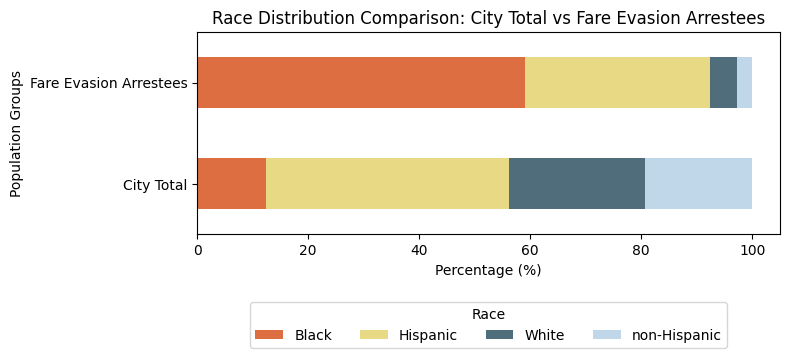

In [139]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 创建 Race Distribution Comparison 数据
# City Total 和 Fare Evasion Arrestees 的种族分布
race_data = pd.DataFrame({
    'Black': [19.590421, 59.007353],
    'Hispanic': [69.444787, 33.363971],
    'White': [38.816017, 4.963235],
    'non-Hispanic': [30.555213, 2.665441]
}, index=['City Total', 'Fare Evasion Arrestees'])

# 2. 对 City Total 的种族比例进行标准化，使其加总为100%
race_data.loc['City Total'] = race_data.loc['City Total'] / race_data.loc['City Total'].sum() * 100

# 3. 设置颜色
colors = ['#DD6E42', '#E8DA84', '#4F6D7A', '#C0D6E9']

# 4. 绘制 Race Distribution Comparison 的水平堆叠条形图
fig, ax = plt.subplots(figsize=(8, 4))
race_data.plot(kind='barh', stacked=True, ax=ax, color=colors)

# 添加标题和标签
plt.title('Race Distribution Comparison: City Total vs Fare Evasion Arrestees')
plt.xlabel('Percentage (%)')
plt.ylabel('Population Groups')

# 调整布局和标签
plt.legend(title='Race', bbox_to_anchor=(0.5, -0.3), loc='upper center', ncol=4)
plt.tight_layout()

# 显示图表
plt.show()


#### 5.2 DI index

In [161]:
print(df_demo.columns)
print(df_arrest_demo.columns)

Index(['Complex_ID', 'Latitude', 'Longitude', 'MEAN_Median_Inc',
       'SUM_Total_Popu', 'SUM_Male_Total', 'SUM_Female_Tot', 'SUM_White_Alon',
       'SUM_Black_Alon', 'SUM_Hispanic_L', 'SUM_Non_Hispan'],
      dtype='object')
Index(['ARREST_DATE', 'ARREST_BORO', 'ARREST_PRECINCT', 'AGE_GROUP',
       'PERP_SEX', 'PERP_RACE', 'Latitude_x', 'Longitude_x',
       'station_complex_id', 'Latitude_y', 'Longitude_y', 'MEAN_Median_Inc',
       'SUM_Total_Popu', 'SUM_Male_Total', 'SUM_Female_Tot', 'SUM_White_Alon',
       'SUM_Black_Alon', 'SUM_Hispanic_L', 'SUM_Non_Hispan', 'Mapped_Race',
       'MODEL_PREDICTION'],
      dtype='object')


In [165]:
df_demo.head()

,Complex_ID,Latitude,Longitude,MEAN_Median_Inc,SUM_Total_Popu,SUM_Male_Total,SUM_Female_Tot,SUM_White_Alon,SUM_Black_Alon,SUM_Hispanic_L,SUM_Non_Hispan
0,398,40.773620,-73.959874,134178.7500,47275,20936,26339,40094,372,44312,2963
1,399,40.768141,-73.963870,177047.8889,44931,19397,25534,36445,576,41252,3679
2,403,40.746081,-73.982076,155538.0000,48537,23030,25507,29953,2794,43228,5309
3,404,40.743070,-73.984264,183811.0000,53878,26223,27655,34329,3474,48862,5016
4,405,40.739864,-73.986599,176921.1000,60407,28990,31417,39826,4033,55036,5371


In [167]:
# 按站点加总每个种族的人口
race_population = {
    'White': df_demo['SUM_White_Alon'].sum(),
    'Black': df_demo['SUM_Black_Alon'].sum(),
    'Hispanic': df_demo['SUM_Hispanic_L'].sum(),
    'Non-Hispanic': df_demo['SUM_Non_Hispan'].sum(),
}

# 输出每个种族的总人口
print(race_population)


{'White': 6378232, 'Black': 3219090, 'Hispanic': 11411139, 'Non-Hispanic': 5020820}


In [163]:
# 计算每个种族群体的逃票逮捕人数
arrest_counts = df_arrest_demo.groupby('Mapped_Race').size()

# 显示每个种族的逃票逮捕人数
print(arrest_counts)


Mapped_Race
0    1284
1     726
2     108
3      58
dtype: int64


In [169]:
# 计算每个种族的 Outcome Rate
outcome_rates = {}
for race in race_population:
    total_population = race_population[race].sum()
    arrest_count = arrest_counts.get(race, 0)  # 如果没有该种族的逮捕记录，设置为0
    outcome_rate = arrest_count / total_population if total_population > 0 else 0
    outcome_rates[race] = outcome_rate

# 显示 Outcome Rates
print(outcome_rates)


{'White': 0.0, 'Black': 0.0, 'Hispanic': 0.0, 'Non-Hispanic': 0.0}


In [171]:
# 假设我们选择全市作为对照群体（可以选择其他对照群体）
reference_outcome_rate = outcome_rates.get('Non-Hispanic', 0)

# 计算每个种族的 DI
disparate_impact = {}
for race, outcome_rate in outcome_rates.items():
    di = outcome_rate / reference_outcome_rate if reference_outcome_rate > 0 else 0
    disparate_impact[race] = di

# 显示 Disparate Impact (DI)
print(disparate_impact)


{'White': 0, 'Black': 0, 'Hispanic': 0, 'Non-Hispanic': 0}


In [175]:
# 提取 df_arrest_demo 中的 Mapped_Race 和 PERP_RACE 两列
df_arrest_race = df_arrest_demo[['Mapped_Race', 'PERP_RACE']]

# 显示提取的数据
print(df_arrest_race)


      Mapped_Race       PERP_RACE
0               0           BLACK
1               0           BLACK
2               0           BLACK
3               1  WHITE HISPANIC
4               0           BLACK
...           ...             ...
2171            0           BLACK
2172            0           BLACK
2173            1  WHITE HISPANIC
2174            1  WHITE HISPANIC
2175            1  WHITE HISPANIC

[2176 rows x 2 columns]
